# Object tracking pipeline

This example shows a basic pipeline that performs object tracking.

Contents:

- Object tracking pipeline with SORT algorithm.
- Object tracking pipeline with DeepSORT algorithm.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from videoanalytics.pipeline import Pipeline
from videoanalytics.pipeline.sources import VideoReader
from videoanalytics.pipeline.sinks import VideoWriter

We will be using the same video as in the previous examples.
Note: the video used in this example was downloaded from [youtube](https://www.youtube.com/watch?v=WgCe0tMO4lA).

In [3]:
DATA_PATH = "../data/"

# Input
INPUT_VIDEO = DATA_PATH+"/input/test_video.mp4"
START_FRAME = 0
MAX_FRAMES = 100

In [4]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/input/test_video.mp4" type="video/mp4">
    </video>
</div>

In [5]:
# Output
OUTPUT_VIDEO = DATA_PATH+ "/output/test_output.avi"

Object tracking requires that objects are identified in each individual frame. To perform this task the same components of the object detection examples will be used in the pipeline.

In [6]:
# Specific components for object detection
from videoanalytics.pipeline.sinks.object_detection import DetectionsAnnotator, DetectionsCSVWriter
from videoanalytics.pipeline.sinks.object_detection.yolo4 import YOLOv4DetectorTF

In [7]:
# Detector

# Object Detector model weights (Tensorflow)
DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-416-tf"
#DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-tiny-416"


# Classes names for Detections Annotator
DETECTOR_CLASSES_FILENAME = DATA_PATH+"object_detection/classes_definitions/coco.txt"

# CSV with Detections filename
DETECTIONS_FILENAME = DATA_PATH+"/output/detections.csv"

## Object tracking pipeline with SORT algorithm

In [8]:
from videoanalytics.pipeline.sinks.object_tracking import TrackedObjectsAnnotator, TrackedObjectsCSVWriter
from videoanalytics.pipeline.sinks.object_tracking.sort import SORT

TRACKED_OBJS_FILENAME = DATA_PATH+"/output/trackings.csv"

In [9]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

# 3.3 Tracker (SORT)
pipeline.add_component( SORT("tracker",context) )

# 3.4 Annotate tracked objects in output video
pipeline.add_component( TrackedObjectsAnnotator("tracker_annotator",context) )

# 3.5 Save trackings to CSV for posterior anayisis
pipeline.add_component( TrackedObjectsCSVWriter("tracker_csv_writer",context, filename = TRACKED_OBJS_FILENAME) )

# 3.6 Output video
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

In [10]:
# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),
    ("detector", "tracker"),
    ("tracker", "tracker_annotator"),
    ("tracker", "tracker_csv_writer"),
    ("tracker_annotator", "writer")
])

In [11]:
pipeline.optimize()

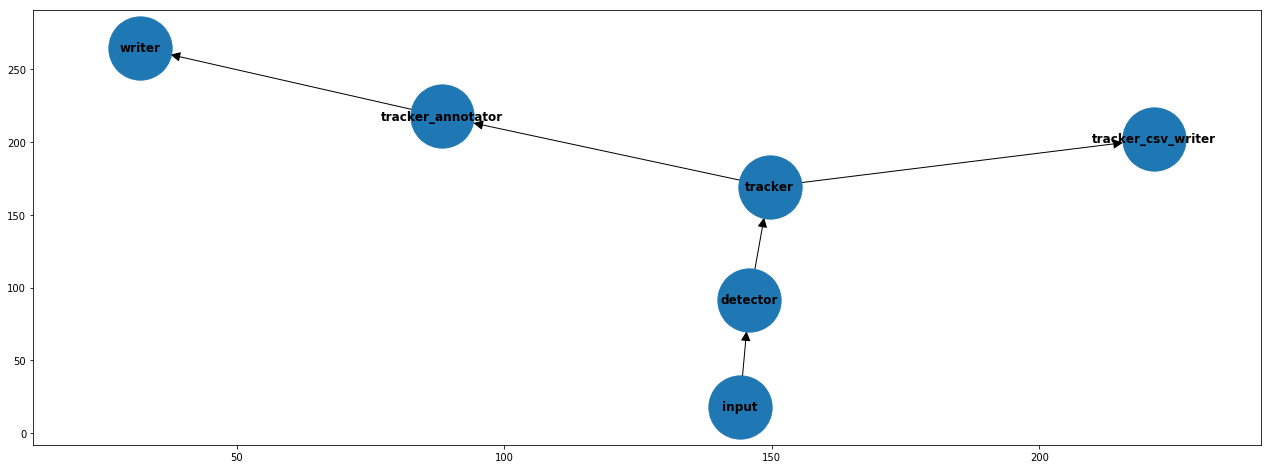

In [12]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [13]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 60.35206350700173


In [14]:
import pandas as pd

# 6. Report (optional)
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
metrics_df

,time [s]
input_avg_dt,0.009327
detector_avg_dt,0.559688
tracker_avg_dt,0.000865
tracker_csv_writer_avg_dt,0.000018
tracker_annotator_avg_dt,0.000330
writer_avg_dt,0.030823


### Exploration of results

Display the output video with annotated bounding boxes.

Note: currently XVID format is not supported by jupyter.

In [15]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/output/test_output.avi" type="video/mp4">
    </video>
</div>

In [16]:
df_tracks = pd.read_csv(TRACKED_OBJS_FILENAME,
                        names=["frame_num","obj_id", "x","y","w","h"])
df_tracks.head(5)

,frame_num,obj_id,x,y,w,h
0,0,2,696,387,111,104
1,0,1,860,361,140,137
2,1,2,696,387,111,104
3,1,1,860,361,140,137
4,2,2,696,387,108,102


## Object tracking pipeline with DeepSORT algorithm

In [17]:
DEEPSORT_MODEL_FILENAME = DATA_PATH+"object_tracking/mars-small128.pb"

In [18]:
from videoanalytics.pipeline.sinks.object_tracking.deepsort import DeepSORT

# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

# 3.3 Tracker (DeepSORT)
pipeline.add_component( DeepSORT("tracker",context,model_filename=DEEPSORT_MODEL_FILENAME) )
pipeline.add_component( TrackedObjectsAnnotator("tracker_annotator",context) )

# 3.3 Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),
    ("detector", "tracker"),
    ("tracker", "tracker_annotator"),
    ("tracker_annotator", "writer")
])

# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 75.83832986899506


In [19]:
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
metrics_df

,time [s]
input_avg_dt,0.007867
detector_avg_dt,0.692927
tracker_avg_dt,0.024441
tracker_annotator_avg_dt,0.000456
writer_avg_dt,0.030239


### Exploration of results

In [20]:
df_tracks = pd.read_csv(TRACKED_OBJS_FILENAME,
                        names=["frame_num","obj_id", "x","y","w","h"])
df_tracks.head(5)

,frame_num,obj_id,x,y,w,h
0,0,2,696,387,111,104
1,0,1,860,361,140,137
2,1,2,696,387,111,104
3,1,1,860,361,140,137
4,2,2,696,387,108,102
